In [10]:
import pandas as pd
from pandas_datareader import wb
import country_converter as coco
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings

warnings.filterwarnings('ignore')

In [48]:
def load_target():
    code = "FM.LBL.BMNY.IR.ZS"
    wbk = wb.download(indicator=code, country="all", start=1960, end=2024)
    wbk = wbk.reset_index()[["country","year",code]].rename(columns={code:"wb_YIELD10Y"})
    wbk["year"] = wbk["year"].astype(int)
    wbk = wbk[~wbk.country.isin(('Africa Eastern and Southern', 'Africa Western and Central',
           'Arab World', 'Caribbean small states',
           'Central Europe and the Baltics', 'Early-demographic dividend',
           'East Asia & Pacific',
           'East Asia & Pacific (excluding high income)',
           'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
           'Europe & Central Asia',
           'Europe & Central Asia (excluding high income)',
           'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
           'Fragile and conflict affected situations',
           'Heavily indebted poor countries (HIPC)', 'High income',
           'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
           'IDA total', 'Late-demographic dividend',
           'Latin America & Caribbean',
           'Latin America & Caribbean (excluding high income)',
           'Latin America & the Caribbean (IDA & IBRD countries)',
           'Least developed countries: UN classification',
           'Low & middle income', 'Low income', 'Lower middle income',
           'Middle East, North Africa, Afghanistan & Pakistan',
           'Middle East, North Africa, Afghanistan & Pakistan (excluding high income)',
           'Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)',
           'Middle income', 'North America', 'Not classified', 'OECD members',
           'Other small states', 'Pacific island small states',
           'Post-demographic dividend', 'Pre-demographic dividend',
           'Small states', 'South Asia', 'South Asia (IDA & IBRD)',
           'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
           'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
           'World', 'Channel Islands', 'Euro area (19 countries)'))]
    
    oecd = pd.read_csv("files/OECD.csv")
    oecd = oecd[(oecd['Frequency of observation']=='Annual') &
                (oecd['Unit of measure']=='Percent per annum') &
                (oecd.TIME_PERIOD>='1960') &
                (oecd.MEASURE=='IRLT')][['Reference area', 'TIME_PERIOD', 'OBS_VALUE'
                                        ]].reset_index(drop=True).rename(columns={'Reference area':'country',
                                                                                  'TIME_PERIOD':'year',
                                                                                  'OBS_VALUE':'oecd_YIELD10Y'})
    
    oecd = oecd[oecd.country!='Euro area (19 countries)']
    oecd["iso3"] = coco.convert(names=oecd["country"], to="ISO3", not_found=None)
    wbk["iso3"] = coco.convert(names=wbk["country"], to="ISO3", not_found=None)
    oecd["country"] = coco.convert(names=oecd["iso3"], to="name_short", not_found=None)
    wbk["country"] = coco.convert(names=wbk["iso3"], to="name_short", not_found=None)
    oecd = oecd[['country', "year", "iso3", "oecd_YIELD10Y"]].assign(source="OECD")
    wbk = wbk[['country', "year", "iso3", "wb_YIELD10Y"]].assign(source="WB")
    
    merged = pd.concat([oecd, wbk])
    merged['yield'] = merged['oecd_YIELD10Y'].fillna(merged['wb_YIELD10Y'])
    merged = merged.drop(columns=['oecd_YIELD10Y', 'wb_YIELD10Y'])
    merged = merged.sort_values(by=['iso3', 'year', 'source']).reset_index(drop=True)
    merged = merged.drop_duplicates(subset=['country', 'year'])
    return merged

In [49]:
df = load_target()

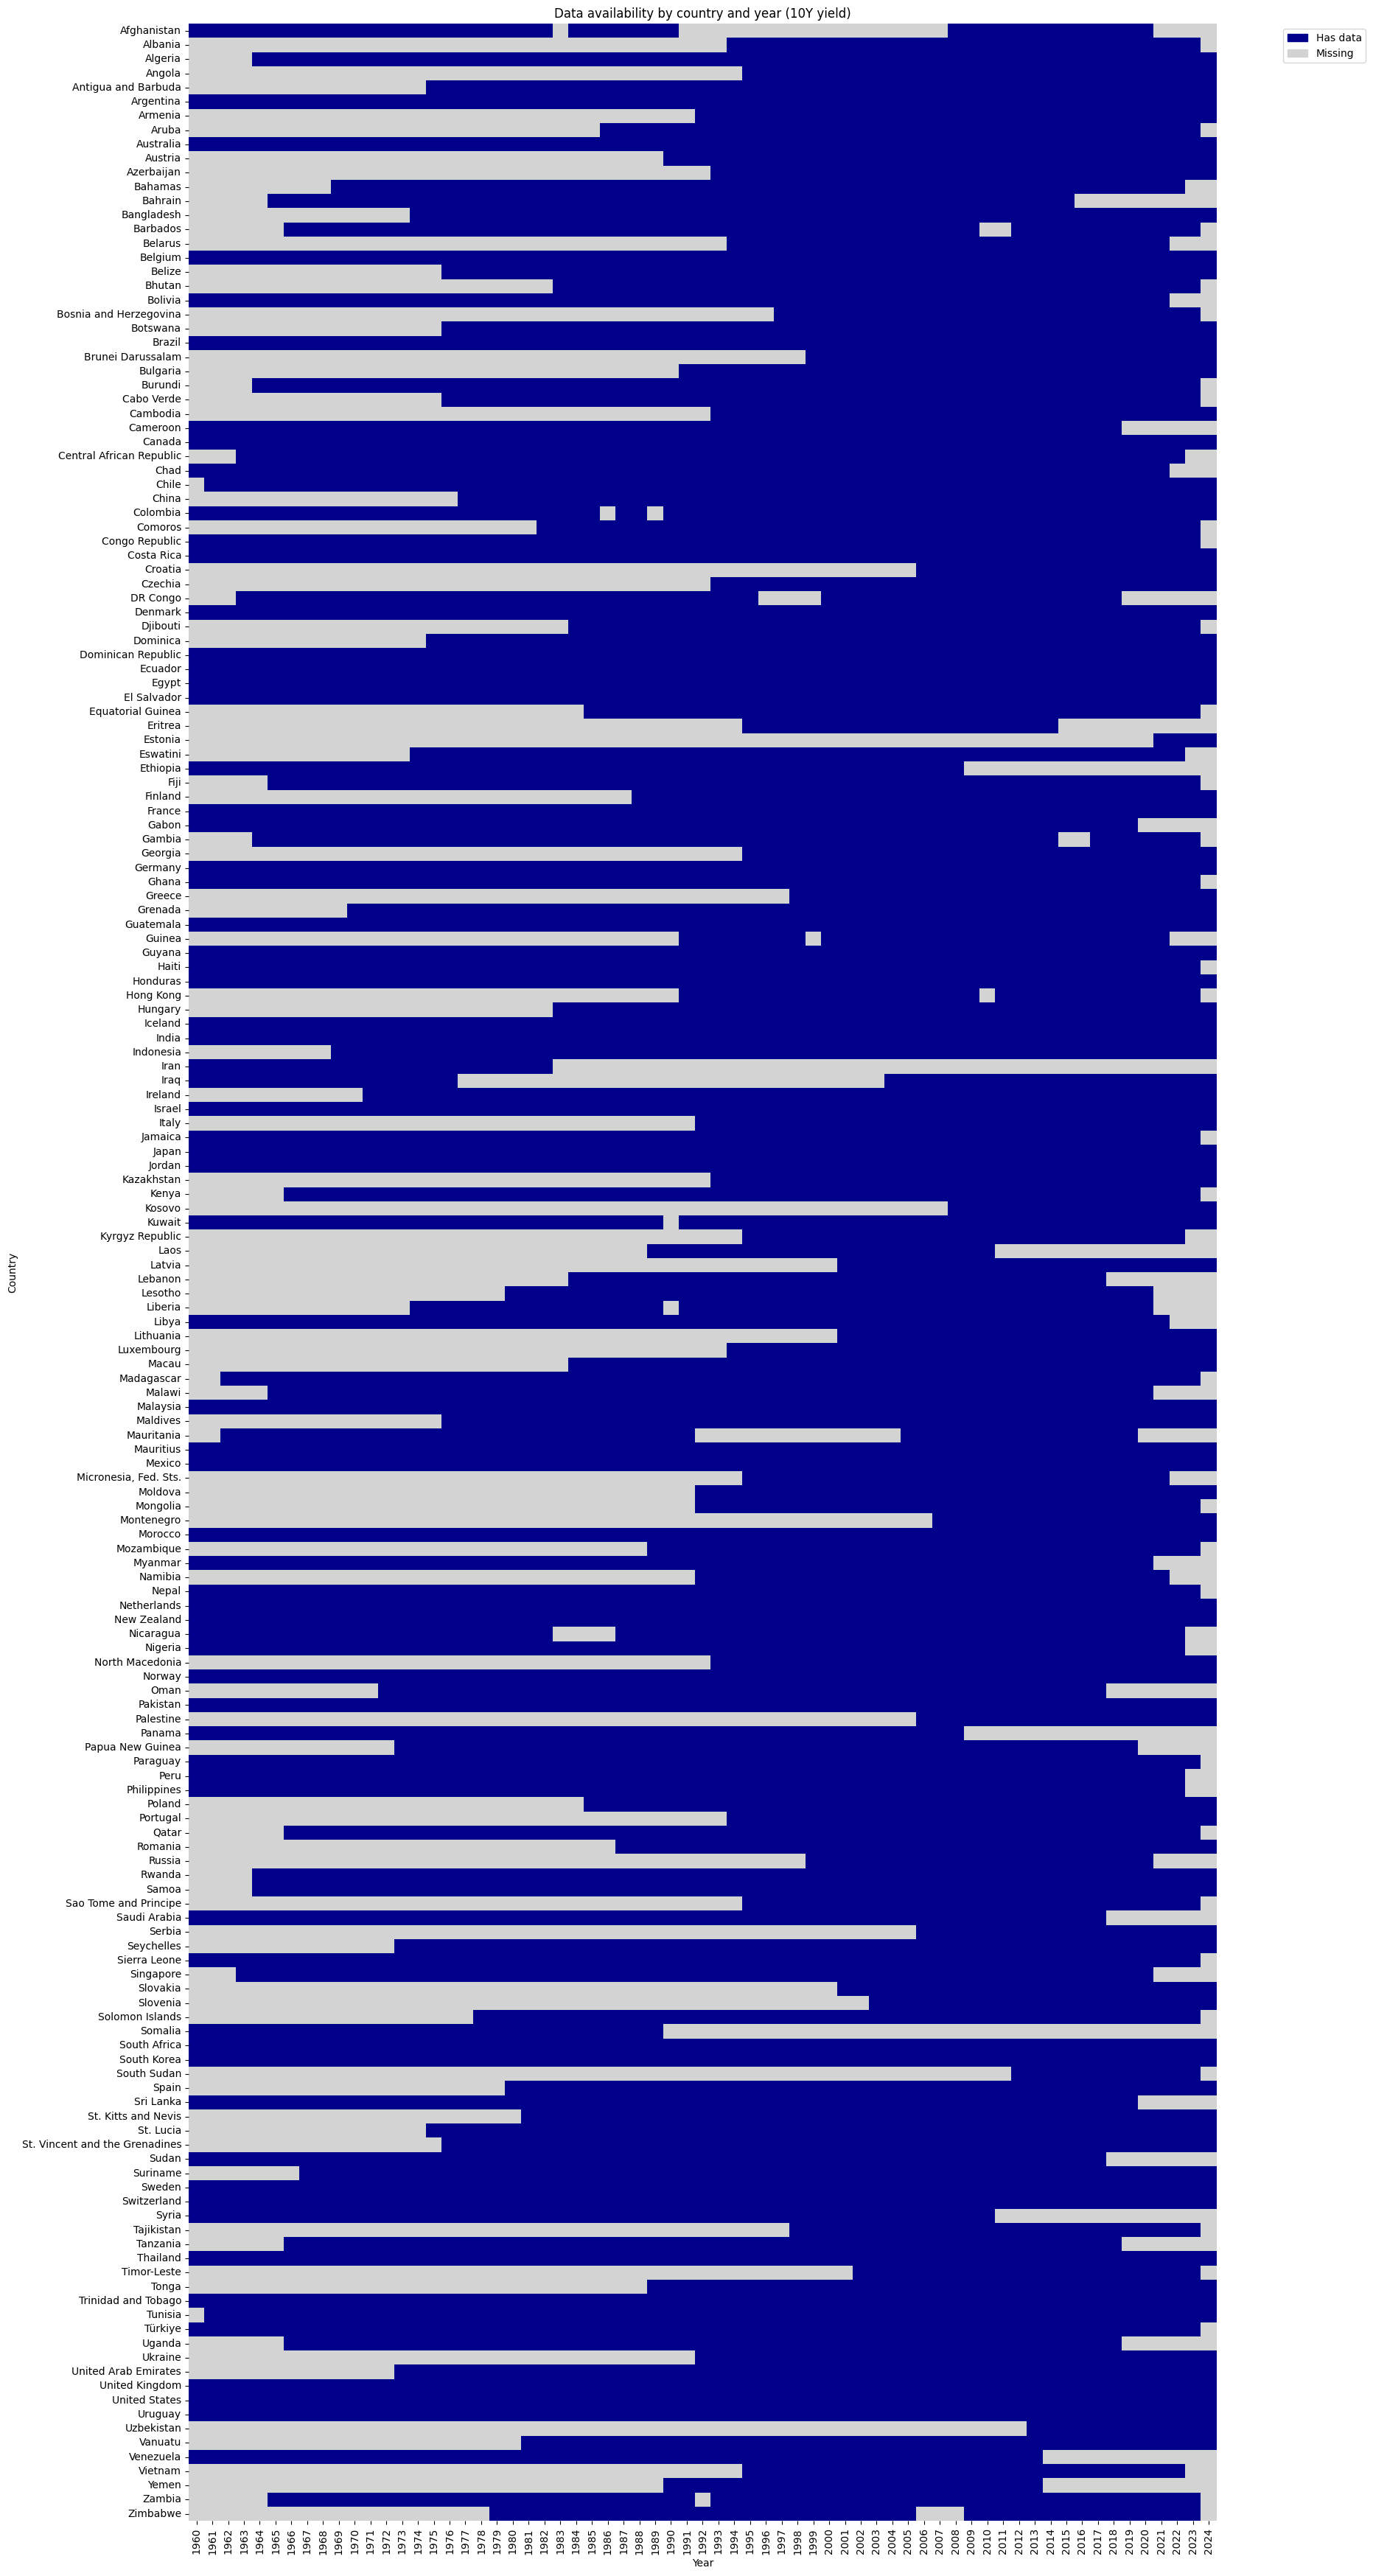

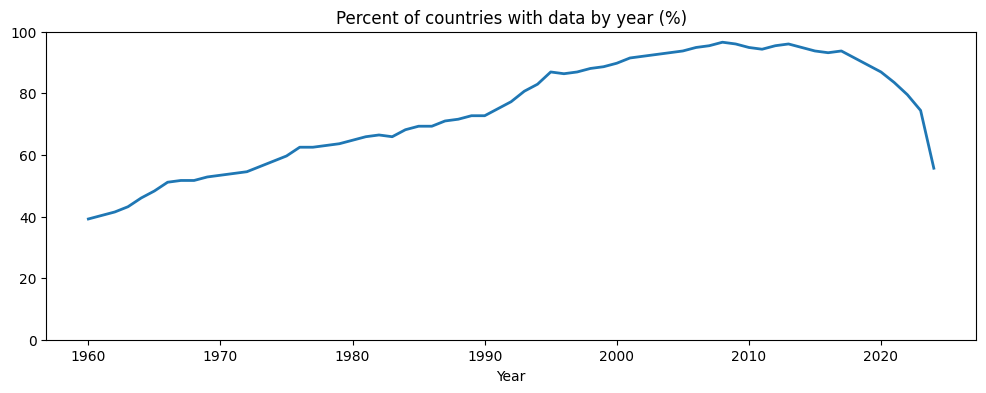

In [91]:
# Clean inputs: make year numeric and within bounds
df2 = df.copy()
df2 = df2[df2.groupby('country')['yield'].transform('count') > 0]
df2['year'] = pd.to_numeric(df2['year'], errors='coerce')
df2 = df2[df2['year'].between(1960, 2024)]

# Build a boolean availability mask via pivot_table (handles duplicates across sources)
# If there are multiple rows per country-year, aggfunc='max' (on the boolean) -> True if ANY source has data
df2['has'] = df2['yield'].notna().astype(int)
mask = df2.pivot_table(index='country', columns='year', values='has',
                       aggfunc='max', fill_value=0).astype(bool)

# Ensure unique, sorted year columns and alphabetical countries
mask.columns = mask.columns.astype(int)
# If some duplicate year labels still sneak in (e.g., after casting), collapse them:
if mask.columns.duplicated().any():
    mask = mask.groupby(mask.columns, axis=1).max()
mask = mask.sort_index(axis=0)  # alphabetical countries
mask = mask.sort_index(axis=1)  # ascending years

# Heatmap of missingness (all countries)
fig, ax = plt.subplots(figsize=(18, max(8, len(mask)/4)))  # auto-scale height
sns.heatmap(mask, cmap=["lightgrey", "darkblue"], cbar=False, ax=ax)
ax.set_title("Data availability by country and year (10Y yield)")
ax.set_xlabel("Year")
ax.set_ylabel("Country")

# Legend
has_data = mpatches.Patch(color="darkblue", label="Has data")
missing  = mpatches.Patch(color="lightgrey", label="Missing")
ax.legend(handles=[has_data, missing], loc="upper right", bbox_to_anchor=(1.15, 1))
plt.show()

# Coverage per year
coverage = mask.sum(axis=0)  # number of countries with data each year
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(coverage.index, coverage.values*100/176, lw=2)
ax.set_title("Percent of countries with data by year (%)")
ax.set_xlabel("Year")
plt.ylim(0,100)
plt.show()